### Link ảnh: https://drive.google.com/drive/u/0/folders/1nw4xwXVEcIgKjWzI5-1qCKr_KECEZkfF

In [0]:
'''
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = "gdrive/My Drive/Digital Signal Processing"
'''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install bitstring
!pip install PyWavelets
!pip install Pillow

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pylab import imread

import pywt
import pywt.data

import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

import bitstring as bs
from PIL import Image
#from scipy.misc import imread
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


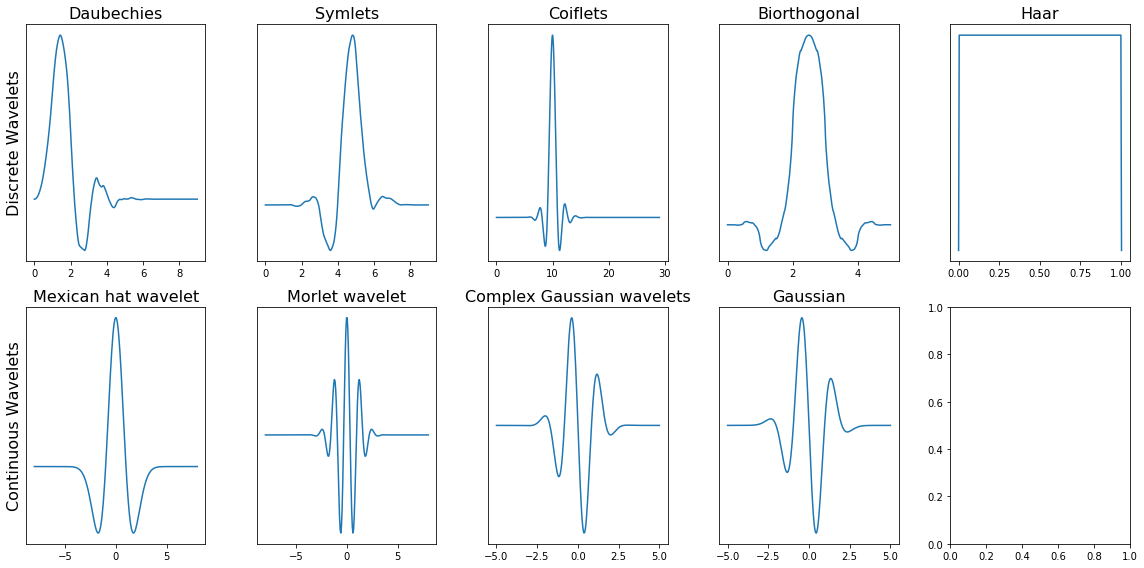

In [0]:
import pywt
import matplotlib.pyplot as plt
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior1.3', 'haar']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
  func = list_funcs[ii]
  row_no = ii
  for col_no, waveletname in enumerate(list_wavelets):
    wavelet = func(waveletname)
    family_name = wavelet.family_name
    biorthogonal = wavelet.biorthogonal
    orthogonal = wavelet.orthogonal
    symmetry = wavelet.symmetry
    if ii == 0:
      _ = wavelet.wavefun()
      wavelet_function = _[0]
      x_values = _[-1]
    else:
      wavelet_function, x_values = wavelet.wavefun()
    if col_no == 0 and ii == 0:
      axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
    if col_no == 0 and ii == 1:
      axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
    axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
    axarr[row_no, col_no].plot(x_values, wavelet_function)
    axarr[row_no, col_no].set_yticks([])
    axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()

In [0]:
def imshows(ImageData, LabelData, rows, cols, gridType = True):
  from matplotlib import pyplot as plt
  fig = plt.figure(figsize = (15, 15))
  for i in range(1, cols * rows + 1):
    fig.add_subplot(rows, cols, i)
    image = ImageData[i - 1]
    if(len(image.shape)< 3):
      plt.imshow(image, plt.cm.gray)
    else:
      plt.imshow(image)
    plt.grid(gridType)
    plt.title(LabelData[i - 1])
  plt.show()

def showPlot(ImageData, LabelData, rows, cols, gridType = True):
  from matplotlib import pyplot as plt
  fig = plt.figure(figsize = (15, 15))
  for i in range(1, cols * rows + 1):
    fig.add_subplot(rows, cols, i)
    image = ImageData[i - 1]
    plt.hist(image.ravel(),60,[0,270]);
    plt.grid(gridType)
    plt.title(LabelData[i - 1])
  plt.show()

def Shape(image):
  return "Shape: " + str(image.shape)
  print()

#**COMPRESS**
#### 1. Scale 2^n x 2^n
#### 2. Quantize
#### 3. Huffman encoding, bitstring

In [0]:
#Scale 2^n x 2^n

import math

def rescale(img):
  e = 0
  if img.shape[0] <= img.shape[1]:
    e = int(math.log(img.shape[0], 2))
  else:
    e = int(math.log(img.shape[1], 2))
  resized = cv2.resize(img, (2**e, 2**e), interpolation = cv2.INTER_AREA)
  return resized

In [0]:
def _recreate(subbands): #sub to coeffs
  coeffs = [subbands[0]]
  for i in range(1, len(subbands), 3):
    t = (subbands[i], subbands[i+1], subbands[i+2])
    coeffs.append(t)
  return coeffs

In [0]:
## Calculating the Wavelet Coefficients

def decompose(img, level):
  subbands = []
  # wavedec2 return [A,(Hn, Vn, Dn)...(H1, V1, D1)]
  coeffs = pywt.wavedec2(img, 'coif1', mode='periodization', level=level)
  # print(len(coeffs))
  subbands.append(coeffs[0])
  for i in range(1,len(coeffs)):
    for j in range(3):
      subbands.append(coeffs[i][j])
  return subbands, coeffs


In [0]:
def get_bins(subbands, image, r, gamma): #r = [0, 1]
  subband_vars = np.zeros(16)
  fracs = np.zeros(16)
  for i in range(len(subbands)): # Compute subband variances.
    X,Y = subbands[i].shape
    fracs[i]=(X*Y)/(np.float(image.shape[0]*image.shape[1]))
    x = np.floor(X/8.).astype(int)
    y = np.floor(9*Y/32.).astype(int)
    Xp = np.floor(3*X/4.).astype(int)
    Yp = np.floor(7*Y/16.).astype(int)
    mu = subbands[i].mean()
    sigsq = (Xp*Yp-1.)**(-1)*((subbands[i][x:x+Xp, y:y+Yp]-mu)**2).sum()
    subband_vars[i] = sigsq
  A = np.ones(16)
  A[13], A[14] = [1.32]*2
  Qprime = np.zeros(16)
  mask = subband_vars >= 1.01
  Qprime[mask] = 10./(A[mask]*np.log(subband_vars[mask]))
  Qprime[:4] = 1
  Qprime[15] = 0
  K = []

  for i in range(15):
    if subband_vars[i] >= 1.01:
      K.append(i)

  while True:
    S = fracs[K].sum()
    P = ((np.sqrt(subband_vars[K])/Qprime[K])**fracs[K]).prod()
    q = (gamma**(-1))*(2**(r/S-1))*(P**(-1./S))
    E = []
    for i in K:
      if Qprime[i]/q >= 2*gamma*np.sqrt(subband_vars[i]):
        E.append(i)
    if len(E) > 0:
      for i in E:
        K.remove(i)
      continue
    break

  Q = np.zeros(16) # Final bin widths.
  for i in K:
    Q[i] = Qprime[i]/q
  Z = 1.2*Q
  return Q, Z

In [0]:
import math

def quantize(subbands, Q, Z):
  q_subbands = []
  # q_subbands = [subbands[0]]
  # tmp_s = subbands[1:]
  for idex, i in enumerate(subbands):
    tmp_i = []
    for j in i:
      tmp_j = [] 
      for a in j:
        #print(a)
        if a > Z[idex]/2:
          if (Q[idex] == 0):
            t = 0;
          else:
            t = math.floor((a - Z[idex]/2)/Q[idex]) + 1
          tmp_j.append(t)
        elif a >= -Z[idex]/2 and a <= Z[idex]/2:
          tmp_j.append(0)
        else:
          if (Q[idex] == 0):
            t = 0;
          else:
            t = math.ceil((a + Z[idex]/2)/Q[idex]) - 1
          tmp_j.append(t)
      #tmp_i = np.asarray(tmp_j)
      tmp_i.append(tmp_j)
    tmp_i = np.asarray(tmp_i)
    tmp_i = np.array(tmp_i)
    # tmp_i = np.array(tmp_i, dtype = int)
    q_subbands.append(tmp_i)
  
  #return np.array(q_subbands,dtype=int)
  return q_subbands

In [0]:
def group(subbands):
  g1 = [] # This will hold the group 1 coefficients.
  s1 = [] # Keep track of the subband dimensions in group 1.
  t1 = [] # Keep track of which subbands were included.
  for i in range(10):
    s1.append(subbands[i].shape)
    if subbands[i].any(): # True if there is any nonzero entry.
      g1.extend(subbands[i].ravel())
      t1.append(True)
    else: # The subband was not transmitted.
      t1.append(False)

  g2 = [] # This will hold the group 2 coefficients.
  s2 = [] # Keep track of the subband dimensions in group 2.
  t2 = [] # Keep track of which subbands were included.
  for i in range(10, 13):
    s2.append(subbands[i].shape)
    if subbands[i].any(): # True if there is any nonzero entry.
      g2.extend(subbands[i].ravel())
      t2.append(True)
    else: # The subband was not transmitted.
      t2.append(False)

  g3 = [] # This will hold the group 3 coefficients.
  s3 = [] # Keep track of the subband dimensions in group 3.
  t3 = [] # Keep track of which subbands were included.
  for i in range(13,16):
    s3.append(subbands[i].shape)
    if subbands[i].any(): # True if there is any nonzero entry.
      g3.extend(subbands[i].ravel())
      t3.append(True)
    else: # The subband was not transmitted.
      t3.append(False)

  return (g1,g2,g3), (s1,s2,s3), (t1,t2,t3)

In [0]:
import queue
class huffmanLeaf():
  def __init__(self, symbol):
    self.symbol = symbol
  
  def makeMap(self, huff_map, path):
    huff_map[self.symbol] = path
  def __str__(self):
    return str(self.symbol)
  def __lt__(self,other):
    return False

class huffmanNode():
  def __init__(self, left, right):
    self.left = left
    self.right = right
  def makeMap(self, huff_map, path):
    self.left.makeMap(huff_map, path + '0')
    self.right.makeMap(huff_map, path + '1')
  def __lt__(self,other):
    return False

In [0]:
def huffman_indices(coeffs):
    N = len(coeffs)
    i = 0
    inds = []
    extra = []
    freqs = np.zeros(254)
    # Sweep through the quantized coefficients.
    while i < N:
    # First handle zero runs.
      zero_count = 0
      while coeffs[i] == 0:
        zero_count += 1
        i += 1
        if i >= N:
          break

      if zero_count > 0 and zero_count < 101:
        inds.append(zero_count - 1)
        freqs[zero_count - 1] += 1
      elif zero_count >= 101 and zero_count < 256: # 8 bit zero run.
        inds.append(104)
        freqs[104] += 1
        extra.append(zero_count)
      elif zero_count >= 256: # 16 bit zero run.
        inds.append(105)
        freqs[105] += 1
        extra.append(zero_count)
      if i >= N:
        break

    # now handle nonzero coefficients
      if coeffs[i] > 74 and coeffs[i] < 256: # 8 bit pos coeff.
        inds.append(100)
        freqs[100] += 1
        extra.append(coeffs[i])
      elif coeffs[i] >= 256: # 16 bit pos coeff.
        inds.append(102)
        freqs[102] += 1
        extra.append(coeffs[i])
      elif coeffs[i] < -73 and coeffs[i] > -256: # 8 bit neg coeff.
        inds.append(101)
        freqs[101] += 1
        extra.append(abs(coeffs[i]))
      elif coeffs[i] <= -256: # 16 bit neg coeff.
        inds.append(103)
        freqs[103] += 1
        extra.append(abs(coeffs[i]))
      else: # Current value is a nonzero coefficient in the range [-73, ←-74].
        inds.append(179 + coeffs[i])
        freqs[179 + coeffs[i].astype(int)] += 1
      i += 1
    return list(map(int,inds)), list(map(int,freqs)), list(map(int,extra))

In [0]:
import queue
def huffman(freqs):
  q = queue.PriorityQueue()
  for i in range(len(freqs)):
    leaf = huffmanLeaf(i)
    q.put((freqs[i], leaf))
  while q.qsize() > 1:
    l1 = q.get()
    l2 = q.get()
    weight = l1[0] + l2[0]
    node = huffmanNode(l1[1], l2[1])
    q.put((weight,node))
  root = q.get()[1]
  huff_map = dict()
  root.makeMap(huff_map, '')
  return huff_map

In [0]:
def encode_show(indices, extra, huff_map):
  bits = bs.BitArray()
  j = 0 # Index for extra array.
  for s in indices: # Encode each huffman index.
    bits.append('0b' + huff_map[s])
    # Encode extra values for exceptional cases.
    if s in [104, 100, 101]: # Encode as 8-bit ints.
      bits.append('uint:8={}'.format(int(abs(extra[j]%(10**10)))))
      j += 1
    elif s in [102, 103, 105]: # Encode as 16-bit ints.
      bits.append('uint:32={}'.format(int(abs(extra[j]%(10**10)))))
      j += 1
  return bits

In [0]:
#Encodes the indices using the Huffman map, then returns the resulting bitstring.
def encode(indices, extra, huff_map):
  import bitstring as bs
  bits_file = bs.BitArray()
  list_bit = []
  j = 0 # Index for extra array.
  for s in indices: # Encode each huffman index.
    bits_file.append('0b' + huff_map[s])
    element2bitArray = bs.BitArray('0b' + huff_map[s])
    list_bit.append(element2bitArray)
    if s in [104, 100, 101]: # Encode as 8-bit ints.
      bits_file.append('uint:8={}'.format(int(extra[j])))
      element2bitArray = bs.BitArray('uint:8={}'.format(int(extra[j])))
      list_bit.append(element2bitArray)
      j += 1
    elif s in [102, 103, 105]: # Encode as 16-bit ints.
      bits_file.append('uint:32={}'.format(int(extra[j])))
      element2bitArray = bs.BitArray('uint:32={}'.format(int(extra[j])))
      list_bit.append(element2bitArray)
      j += 1
  return bits_file, list_bit

In [0]:
def writeFile(name, bitstrings, type_image):
  file = open(name, "w+b")
  for i in range(3):
    binary_format = bytearray(bitstrings[i])
    file.write(binary_format)
  

In [0]:
def compress(image):
  subbands, coeffs = decompose(image, 5)

  #Quantization
  Q, Z = get_bins(subbands, image, 0.2, 4) # Ngoài khoảng [0, 1] mất dữ liệu nhiều
  q_subbands = quantize(subbands, Q, Z)

  # Complete the Huffman encoding and transfer to bitstring
  groups, shapes, tvals = group(q_subbands)

  infoGroup = [shapes, tvals]
  # indexs = []
  # freq = []
  # extr = []

  huff_maps = [] #type: dictionary
  bitstrings = []
  bitsArr = []
  for i in range(3):
    inds, freqs, extra = huffman_indices(groups[i])

    huff_map = huffman(freqs)
    huff_maps.append(huff_map)
    bs, ba = encode(inds, extra, huff_map)
    bitstrings.append(bs)
    bitsArr.append(ba)

  arr, coeff_slices = pywt.coeffs_to_array(coeffs)
  imshows([image, arr], ["Image", "Compress"], 1, 2)

  return Q, Z, infoGroup, huff_maps, bitsArr, bitstrings

In [0]:
def compress_gray(image):
  Q, Z, infoGroup, huff_maps, bitsArr, bitstrings = compress(image)
  writeFile('Compress_Gray_Image', bitstrings, 0)
  return Q, Z, infoGroup, huff_maps, bitsArr, bitstrings

In [0]:
def compress_color(image, color_space):
  color_image = image.copy()
  if(color_space == "HSV"):
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2HSV)
  elif(color_space == "YUV"):
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2YUV)

  color_compress = []
  bits = []
  for i in range(3):
    # Q, Z, infoGroup, huff_maps, bitsArr, bitstrings = compress(original_rescaled)
    tmp = compress(color_image[:,:,i])
    color_compress.append(tmp)
    bits.append(tmp[-1])
    writeFile('Compress_Color_'+color_space+'_Image', tmp[-1], 1)
  return color_compress, bits

#**DECOMPRESS**

#### Return the uncompressed image recovered from the compressed bistring representation.
#### 1. Decode
#### 2. Ungroup
#### 3. Dequantize
#### 4. Construct

In [0]:
def decode(bits, huff_map):
  import bitstring as bs
  indices = []
  extra = []
  # Reverse the huffman map to get the decoding map.
  dec_map = {v:k for k, v in huff_map.items()}
  # Read each bit at a time, decoding as we go.
  i = 0 # The index of the current bit.
  # pattern = '' # The current bit pattern.

  while i < len(bits):
    pattern = bits[i].bin
    i += 1

    # Check if current pattern is in the decoding map.
    if pattern in dec_map:
      indices.append(dec_map[pattern]) # Insert huffman index.

      # If an exceptional index, read next bits for extra value.
      if dec_map[pattern] in (100, 101, 104): # 8-bit int or 8-bit ←-zero run length.
        extra.append(bits[i].uint)
        i += 1
      elif dec_map[pattern] in (102, 103, 105):
        extra.append(bits[i].uint)
        i += 1

  return indices, extra

In [0]:
# ind_dec = []
# ex_dec = []
# for i in range(3):
#   t, tt = decode(bitsArr[i], huff_maps[i])
#   ind_dec.append(t)
#   ex_dec.append(tt)

In [0]:
def indices_to_group(indices, extra): #Miss data here
  group = []
  j = 0 # Index for extra array.
  
  for s in indices:   
    if s < 100: # Zero count of 100 or less.
      group.extend(np.zeros(s+1))
    elif s == 104 or s == 105: # Zero count of 8 or 16 bits.
      group.extend(np.zeros(extra[j]))
      j += 1
    elif s in [100, 102]: # 8 or 16 bit pos coefficient.
      group.append(extra[j]) # Get the coefficient from the extra ←-list.
      j += 1
    elif s in [101, 103]: # 8 or 16 bit neg coefficient.
      group.append(-extra[j]) # Get the coefficient from the extra ←-list.
      j += 1
    else: # Coefficient from -73 to +74.
      group.append(s-179)
  return group

In [0]:
def ungroup(gs, ss, ts):
  subbands = []
  i = 0
  
  for j, shape in enumerate(ss[0]):
    if ts[0][j]: # True if the j-th subband was included.
      l = shape[0]*shape[1] # Number of entries in the subband
      subbands.append(np.array(gs[0][i:i+l]).reshape(shape))   
      i += l
    else:
      subbands.append(np.zeros(shape))

  subbands1 = [] # The reconstructed subbands in group 2.
  i = 0
  for j, shape in enumerate(ss[1]):#Number of entries in the subband
    if ts[1][j]: # True if the j-th subband was included.
      l = shape[0]*shape[1] # Number of entries in the subband.
      subbands1.append(np.array(gs[1][i:i+l]).reshape(shape))
      i += l
    else: # The j-th subband wasn't included, so all zeros.
      subbands1.append(np.zeros(shape))
  
  subbands2 = [] # the reconstructed subbands in group 3
  i = 0
  for j, shape in enumerate(ss[2]):
    if ts[2][j]: # True if the j-th subband was included.
      l = shape[0]*shape[1] # Number of entries in the subband.
      subbands2.append(np.array(gs[2][i:i+l]).reshape(shape))
      i += l
    else: # The j-th subband wasn't included, so all zeros.
      subbands2.append(np.zeros(shape))

  subbands.extend(subbands1)
  subbands.extend(subbands2)
  return subbands

In [0]:
def dequantize(q_subbands, Q, Z, C = 0.44):
  d_subbands = []
  # d_subbands = [q_subbands[0]]
  # tmp_s = q_subbands[1:]
  for idex, i in enumerate(q_subbands):
    tmp_i = []
    for j in i:
      tmp_j = []
      for a in j:
        if a > 0:
          t = (a - C)*Q[idex] + Z[idex]/2
          tmp_j.append(t)
        elif a == 0:
          tmp_j.append(0)
        else:
          t = (a + C)*Q[idex] - Z[idex]/2
          tmp_j.append(t)
      tmp_i.append(tmp_j)
    tmp_i = np.asarray(tmp_i)
    tmp_i = np.array(tmp_i)
    d_subbands.append(tmp_i)
  return d_subbands

In [0]:
def reconstruct(coeffs):
  reconstruct = pywt.waverec2(coeffs, 'coif1', mode='periodization', axes=(-2, -1))
  return reconstruct

In [0]:
def decompress(Q, Z, infoGroup, huff_maps, bitsArr):
  groups_decode = []

  for i in range(3):
    indices, extras = decode(bitsArr[i], huff_maps[i])
    groups_decode.append(indices_to_group(indices, extras))

  q_subbands_after_ungroup = ungroup(groups_decode, infoGroup[0], infoGroup[1])

  deQT = dequantize(q_subbands_after_ungroup, Q, Z)
  coeffs_deQT = _recreate(deQT)

  image_de = reconstruct(coeffs_deQT)
  return image_de

In [0]:
def decompress_gray(Q, Z, infoGroup, huff_maps, bitsArr):
  gray_dec = decompress(Q, Z, infoGroup, huff_maps, bitsArr)
  return gray_dec

In [0]:
def decompress_color(compressArr, color_space):
  color_tmp = []
  for i in compressArr:
    color_tmp.append(decompress(i[0], i[1], i[2], i[3], i[4]))
  
  color_de = np.zeros((len(color_tmp[0]), len(color_tmp[0][0]), 3))
  color_de[:,:,0] = color_tmp[0]
  color_de[:,:,1] = color_tmp[1]
  color_de[:,:,2] = color_tmp[2]
  color_de = np.uint8(color_de)

  if color_space == "HSV":
    color_de = cv2.cvtColor(color_de, cv2.COLOR_HSV2RGB)
  elif color_space == "YUV":
    color_de = cv2.cvtColor(color_de, cv2.COLOR_YUV2RGB)
  return color_de

#**MEASURES**

In [0]:
#Calculating PSNR using RMSE - custom function
def psnr(img1, img2):
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return (20 * math.log10(PIXEL_MAX / math.sqrt(mse)))

#Calculating PSNR using MSE - custom function
def compute_psnr(img1, img2):
  img1 = img1.astype(np.float64)/255.
  img2 = img2.astype(np.float64)/255.
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return "Same Image"
  return (10 * math.log10(1. / mse))

# #Calculating PSNR using in-built function
# def get_psnr(img1 , img2):
#   psnr = cv2.PSNR(img1, img2)
#   return psnr

##Calculating PSNR using in-built function
def compression_ratio(original, bitstrings):
  bit = bytes(bitstrings[0]) + bytes(bitstrings[1]) + bytes(bitstrings[2]) 
  ratio = len(bytes(original))/len(bit)
  return ratio

def ratio_color_image(original, bits):
  bit = bytes()
  for i in range(len(bits)):
    for j in range(len(bits[i])):
      bit += bytes(bits[i][j])
  ratio = len(bytes(original))/len(bit)
  return ratio

#**DEMO**

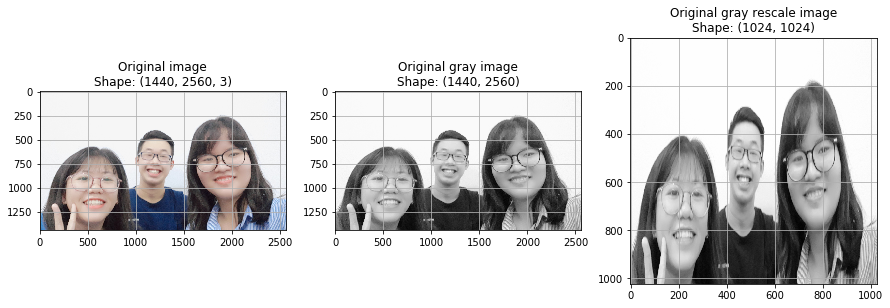

In [0]:

#original = imread(path + "/zoo.jpg")
original = imread('myteam.jpg')
original_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
original_rescaled = rescale(original_gray)
list_title = ["Original image\n{}".format(Shape(original)), "Original gray image\n{}".format(Shape(original_gray)), "Original gray rescale image\n{}".format(Shape(original_rescaled))]
imshows([original, original_gray, original_rescaled], list_title, 1, 3)


In [0]:
cv2.imwrite("ss.jpg", original)

True

### **GRAY IMAGE**



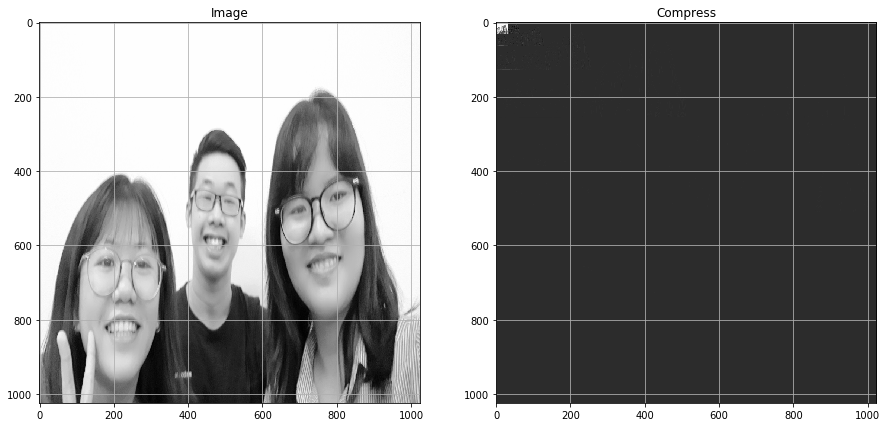

In [0]:
Q, Z, infoGroup, huff_maps, bitsArr, bitstrings = compress_gray(original_rescaled)

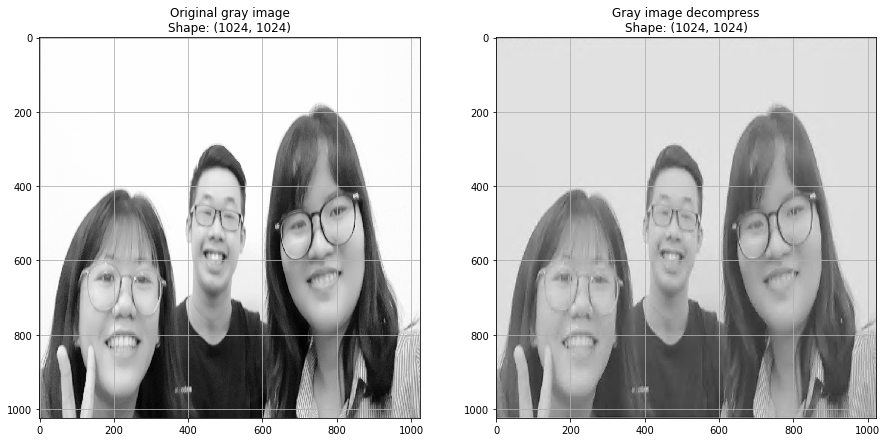

In [0]:
gray_dec = decompress_gray(Q, Z, infoGroup, huff_maps, bitsArr)
imshows([original_rescaled, gray_dec], ["Original gray image\n{}".format(Shape(original_rescaled)), "Gray image decompress\n{}".format(Shape(gray_dec))], 1, 2)

In [0]:
print('PSNR using RMSE: ', psnr(original_rescaled, gray_dec))
print('PSNR using MSE: ', compute_psnr(original_rescaled, gray_dec))
print('RATIO Compression: ', int(compression_ratio(original_rescaled, gray_dec)))

PSNR using RMSE:  32.98169517410035
PSNR using MSE:  32.98169517410035
RATIO Compression:  42


###**COLOR IMAGE**


> **RGB Channel**




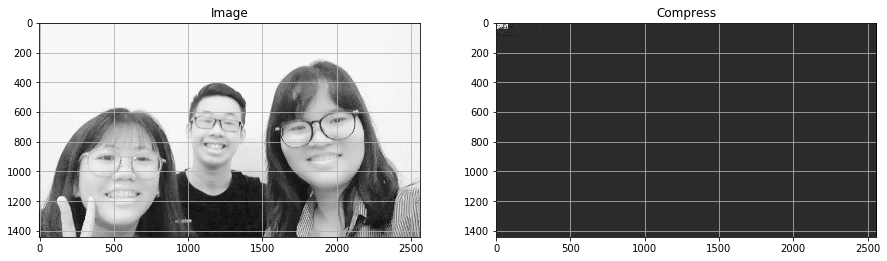

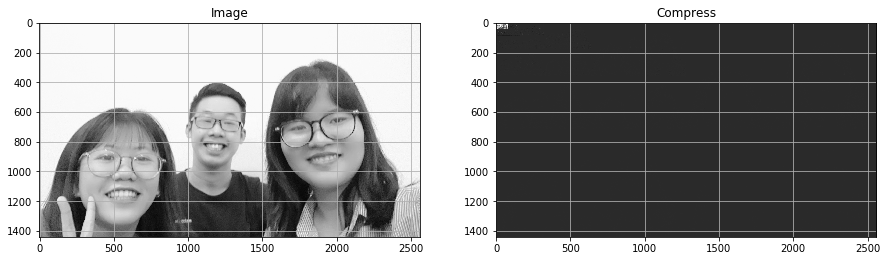

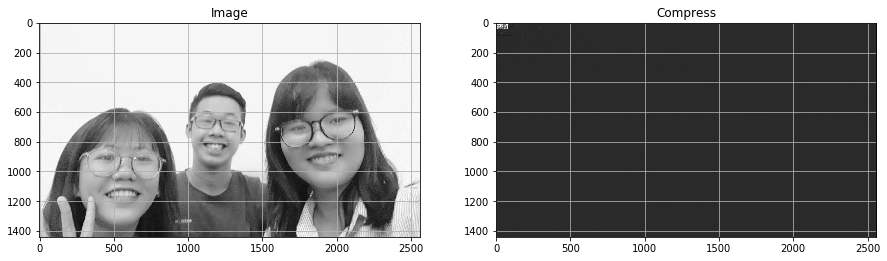

In [0]:
rgb_compress, bits_RGB = compress_color(original, "RGB")

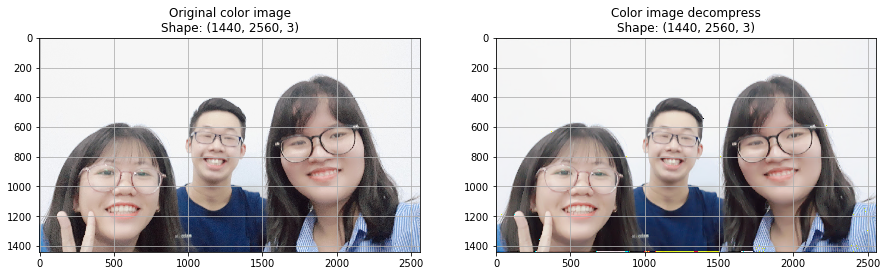

In [0]:
rgb_dec = decompress_color(rgb_compress, "RGB")
imshows([original, rgb_dec], ["Original color image\n{}".format(Shape(original)), "Color image decompress\n{}".format(Shape(rgb_dec))], 1, 2)


> **HSV Channel**




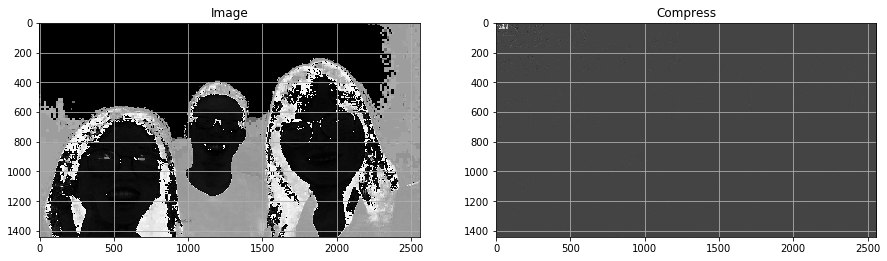

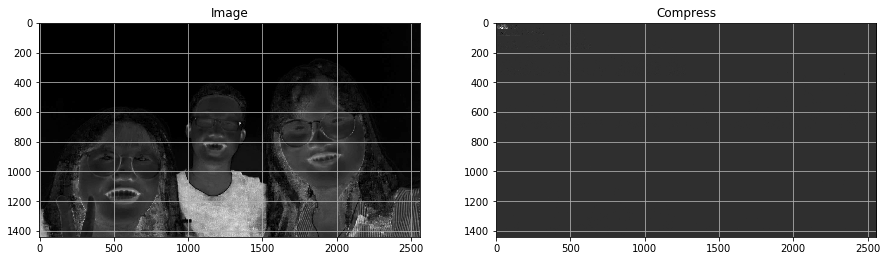

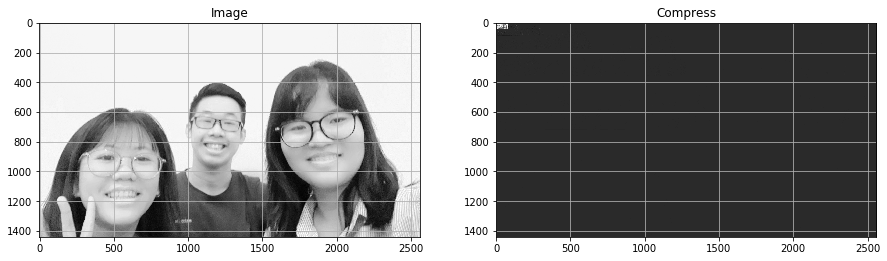

In [0]:
hsv_compress, bits_HSV = compress_color(original, "HSV")

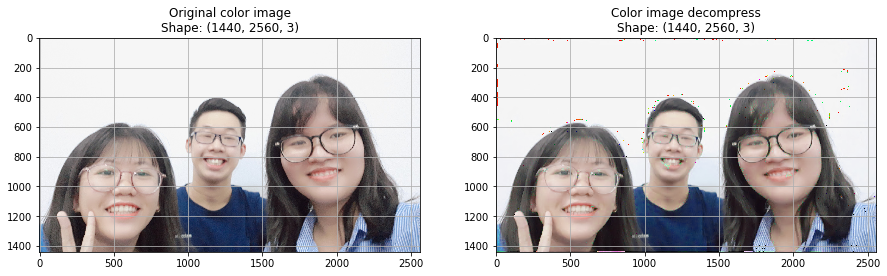

In [0]:
hsv_dec = decompress_color(hsv_compress, "HSV")
imshows([original, hsv_dec], ["Original color image\n{}".format(Shape(original)), "Color image decompress\n{}".format(Shape(hsv_dec))], 1, 2)


> **YUV Channel**




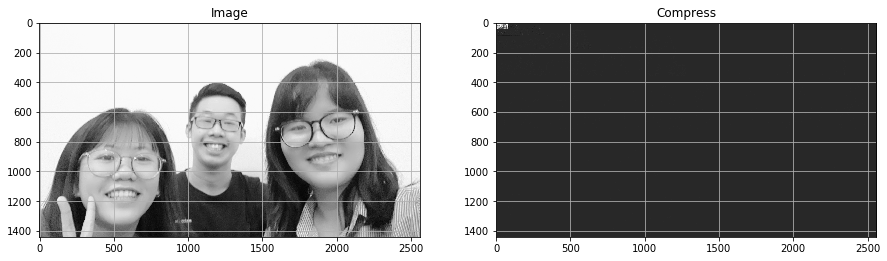

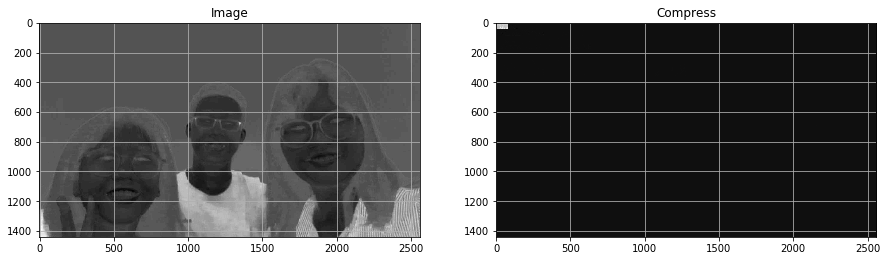

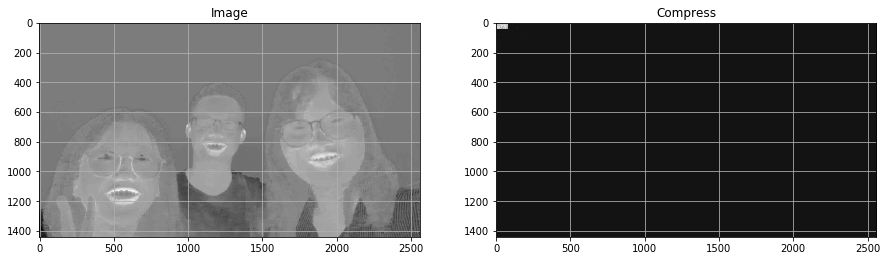

In [0]:
yuv_compress, bits_YUV = compress_color(original, "YUV")

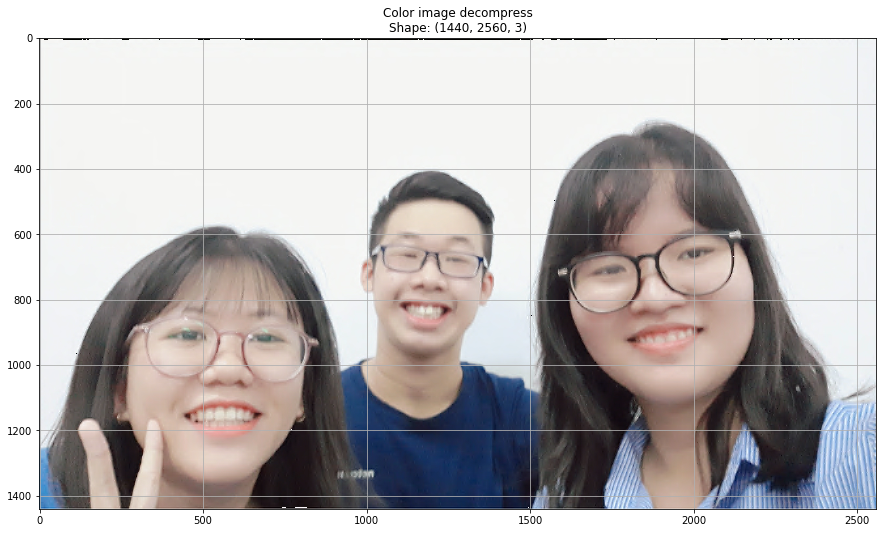

In [0]:
yuv_dec = decompress_color(yuv_compress, "YUV")
# imshows([original, yuv_dec], ["Original color image\n{}".format(Shape(original)), "Color image decompress\n{}".format(Shape(yuv_dec))], 1, 2)
imshows([yuv_dec], ["Color image decompress\n{}".format(Shape(yuv_dec))], 1, 1)

In [0]:
print("RGB Channel:")
print('PSNR using RMSE: ', psnr(original, rgb_dec))
print('PSNR using MSE: ', compute_psnr(original, rgb_dec))
print('RATIO Compression: ', int(ratio_color_image(original, bits_RGB)))

print("\nHSV Channel:")
print('PSNR using RMSE: ',psnr(original, hsv_dec))
print('PSNR using MSE:', compute_psnr(original, hsv_dec))
print('RATIO Compression: ', int(ratio_color_image(original, bits_HSV)))

print("\nYUV Channel:")
print('PSNR using RMSE: ', psnr(original, yuv_dec))
print('PSNR using MSE: ', compute_psnr(original, yuv_dec))
print('RATIO Compression: ', int(ratio_color_image(original, bits_YUV)))

RGB Channel:
PSNR using RMSE:  37.98222428924498
PSNR using MSE:  30.91071750907053
RATIO Compression:  9

HSV Channel:
PSNR using RMSE:  36.88648119259562
PSNR using MSE: 25.683514783989416
RATIO Compression:  11

YUV Channel:
PSNR using RMSE:  37.37607969325096
PSNR using MSE:  31.063991705833605
RATIO Compression:  7


In [0]:
cv2.imwrite( "output_gray_image.png", gray_dec)
cv2.imwrite( "output_color_image.png", yuv_dec)
cv2.imwrite( "output_original_image.png", original)

True